In [1]:
from aux_train import *
from aux_plot import *
from IPython.display import clear_output

In [2]:
default_equation='transp_equation'
default_WENO='WENO-Z-DS'

default_poly_grade=7
default_seno_ampli=3 
default_gauss_var=3
default_seizures=3

In [3]:
def f_test(x):
    z = tf.constant(-0.7, dtype=float_pres)
    δ = tf.constant(0.005, dtype=float_pres)
    β = tf.math.log(tf.constant(2.0, dtype=float_pres))/(36.0*(δ**2.0))
    a = tf.constant(0.5, dtype=float_pres)
    α = tf.constant(10, dtype=float_pres)
    
    def G(x, β, z):
        return tf.math.exp(-β*(x-z)**2)
    
    def F(x, α, a):
        return tf.math.sqrt(tf.math.maximum(1-(α**2)*((x-a)**2),0))
    
    f1 = (G(x, β, z-δ) + 4*G(x, β, z) + G(x, β, z+δ))/6 # x in [-0.8, -0.6]
    f2 = 1                                              # x in [-0.4, -0.2]
    f3 = 1-tf.math.abs(10*(x-0.1))                      # x in [ 0.0,  0.2]
    f4 = (F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))/6 # x in [ 0.4,  0.6]
    f5 = 0                                              # otherwise
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.8),
        tf.math.less_equal(x, -0.6)
    )
    f1 = f1*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.4),
        tf.math.less_equal(x, -0.2)
    )
    f2 = f2*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.0),
        tf.math.less_equal(x, 0.2)
    )
    f3 = f3*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.4),
        tf.math.less_equal(x, 0.6)
    )
    f4 = f4*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    f = f1 + f2 + f3 + f4 + f5
    
    return f

x,fx=create_f_points(f_test=f_test,Δx=0.01)

In [4]:
data_temporal,data_spatial,data_base,Δx,Δt,CFL,fronteira,equation=load_dataset(f'datasets/equation={default_equation} polys grau={default_poly_grade} seno_ampli={default_seno_ampli} gauss_var={default_gauss_var} seizure={default_seizures}')

indice = np.arange(data_temporal.shape[0])
np.random.shuffle(indice)
data_x = data_temporal.astype('float64')[indice]
data_y = data_temporal.astype('float64')[indice]

train_x = data_x[:,0:-1]
train_y = data_y[:,1:]

'Δx': 0.015625
'Δt': 0.004
'CFL': 0.5
'fronteira': <function FronteiraPeriodica at 0x0000015D86B7F550>
'equation': <class 'aux_equation.transp_equation'>
'seed': None



In [11]:
def train(equation_name,poly_grade,seno_ampli,gauss_var,seizures):

    data_temporal,data_spatial,data_base,Δx,Δt,CFL,fronteira,equation=load_dataset(f'datasets/equation={equation_name} polys grau={poly_grade} seno_ampli={seno_ampli} gauss_var={gauss_var} seizure={seizures}')

    indice = np.arange(data_temporal.shape[0])
    np.random.shuffle(indice)
    data_x = data_temporal.astype('float64')[indice]
    data_y = data_temporal.astype('float64')[indice]

    train_x = data_x[:,0:-1]
    train_y = data_y[:,1:]

    Sim_layer = WENO_temporal_layer(equation,WENO_Z,Δx=Δx,Δt=Δt,fronteira=fronteira,regul_weight=0,ativ_func=tf.nn.sigmoid,p=2,conv_size=5)

    input_x   = keras.layers.Input(train_x.shape[1:], dtype='float64')
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    output_x=keras.layers.TimeDistributed(Sim_layer)(input_x)

    # Criando a rede neural
    Network = keras.Model(input_x, output_x)
    Network.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error'])

    loss=Network.fit(
                train_x                           , # Dados de treino
                train_y                           , # Dados de treino
                batch_size      = 16               , # Tamanho do batch
                epochs          = 90              , # Número de epochs
                steps_per_epoch = 10              , # Número de epochs
                shuffle         = True              # Aleatorização dos batchs]
            )
        #wandb.log({"loss": loss, "epoch": epoch})
    Δt=0.01*CFL
    total_time=int(2*1/Δt)
    prev_fx=fx[...]
    count=0
    for i in range(total_time):
        if(i%10==0):
            print(count,end='\r')
        prev_fx=Sim_layer.Sim_step(prev_fx,Δt, 0.01, FronteiraPeriodica)
        count+=Δt

    #prev_fx=Sim_layer.Sim(fx,2*(3), 0.01, CFL, FronteiraPeriodica)
    erro=2*tf.math.reduce_mean(tf.abs(prev_fx-fx))/0.01
    return Network,Sim_layer,prev_fx,fx

In [27]:
Sim_layer = WENO_temporal_layer(equation,WENO_Z,Δx=Δx,Δt=Δt,fronteira=fronteira,regul_weight=0,ativ_func=tf.nn.sigmoid,p=2,conv_size=5)

input_x   = keras.layers.Input(train_x.shape[1:], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

output_x=keras.layers.TimeDistributed(Sim_layer)(input_x)

# Criando a rede neural
Network1 = keras.Model(input_x, output_x)
Network1.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error'])

In [29]:
Network1.set_weights(Network.weights)

In [12]:
Network,prev_fx,fx=train('transp_equation',5,3,3,3)

'Δx': 0.015625
'Δt': 0.004
'CFL': 0.5
'fronteira': <function FronteiraPeriodica at 0x0000015D86B7F550>
'equation': <class 'aux_equation.transp_equation'>
'seed': None

Epoch 1/90
10/10 [==============================] - 25s 1s/step - loss: 1.1970e-04 - mean_absolute_error: 0.0015
Epoch 2/90
10/10 [==============================] - 11s 1s/step - loss: 1.2493e-04 - mean_absolute_error: 0.0015
Epoch 3/90
10/10 [==============================] - 11s 1s/step - loss: 1.2346e-04 - mean_absolute_error: 0.0015
Epoch 4/90
10/10 [==============================] - 11s 1s/step - loss: 1.2734e-04 - mean_absolute_error: 0.0015
Epoch 5/90
10/10 [==============================] - 11s 1s/step - loss: 1.1808e-04 - mean_absolute_error: 0.0014
Epoch 6/90
10/10 [==============================] - 11s 1s/step - loss: 1.2691e-04 - mean_absolute_error: 0.0016
Epoch 7/90
10/10 [==============================] - 11s 1s/step - loss: 1.2587e-04 - mean_absolute_error: 0.0015
Epoch 8/90
10/10 [=======================

In [35]:
Sim_Z=simulation(API_Numpy,equation,WENO_Z)
Z_fx=Sim_Z.Sim(fx,2,0.01,0.5,FronteiraPeriodica)
DS_fx=fx[...]
Δt=0.01*CFL
total_time=int(2*1/Δt)
count=0
for i in range(total_time):
        if(i%10==0):
            print(count,end='\r')
        DS_fx=Sim_layer.Sim_step(DS_fx,Δt, 0.01, FronteiraPeriodica)
        count+=Δt

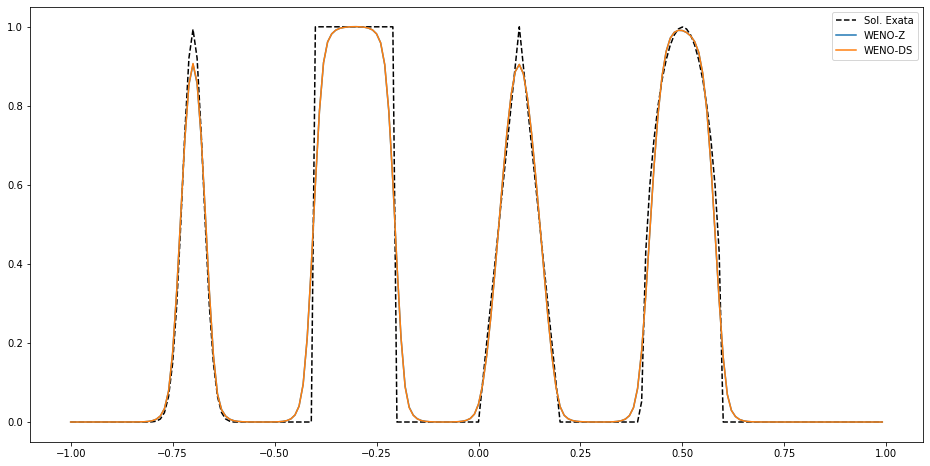

In [36]:
plt.figure(figsize=[16,8])
plt.plot(x,fx[0],label='Sol. Exata',color='black',linestyle='--')
plt.plot(x,Z_fx[0],label='WENO-Z')
plt.plot(x,DS_fx[0],label='WENO-DS')
plt.legend()